In [1]:
# Start ferret
import pyferret
import numpy as np
pyferret.start(quiet=True)


True

In [2]:
# Load the data set and store as a Python variable
# Python dictionaries are a type of variable that
# stores the data along with its metadata.
(error_value, error_message) = pyferret.run('use /home/jovyan/data/1_mesh_mask.nc')
glamt_dict = pyferret.getdata('glamt',False)
gphit_dict = pyferret.getdata('gphit',False)

# Also, use some existing masking in Ferret to zero
# out any area points.
(error_value, error_message) = pyferret.run('let area = e1t[d=1]*e2t[d=1]*tmask[d=1,k=1]')
area_masked_dict = pyferret.getdata('area',False)

(error_value, error_message) = pyferret.run('let area = e1t[d=1]*e2t[d=1]')
area_dict = pyferret.getdata('area',False)

# The "keys" are the names of the entries in the
# dictionary - its pieces.
glamt_dict.keys()

dict_keys(['title', 'data', 'missing_value', 'data_unit', 'axis_types', 'axis_names', 'axis_units', 'axis_coords'])

In [3]:
# Get data directly from the dictionary object (which
# includes metadata) and squeeze out unnecessary
# index places.
glamt = np.squeeze(glamt_dict['data'])
gphit = np.squeeze(gphit_dict['data'])
area = np.squeeze(area_dict['data'])
area_masked = np.squeeze(area_masked_dict['data'])

# Get the sizes of the arrays. _m -> max
im,jm = np.shape(glamt)

np.shape(glamt_dict['data'])

(1784, 1719, 1, 1, 1, 1)

In [4]:
# Need to rotate the array to plot North upward
# Experiments with this suggest that it doesn't
# work as I initially expected.
# Need to do more experiments.
#glamt = np.reshape(glamt,(jm,-1), order='C')
#gphit = np.reshape(gphit,(jm,-1), order='C')

# Instead, here we need to specify the other grid
# parameters. 
# Depth is always 1 for this dataset.
km = 1  
# Start at 731 (1st snap after 10 years of spin up, 1958)
# End at 4526 (endpoint of data set, note +1 for python)
lstart = 731
lend = 735
#lend = 4526
lmn = lend - lstart + 1

# And now specify the amount of cutting down ( _bm ->
# blockmean) and the size of the output array.  Grid
# can be selectively cut in x(i) or y(j) axis.  For
# example, 20 on a 1/20 deg. grid -> 1 degree output.
ibm = 100
jbm = 100

# The new max values, _mn, are calculated here.  Any partial
# boxes on the far Northern/Eastern side will be ignored.
imn = int(im/ibm)
jmn = int(jm/jbm)

# Create output arrays
glamt_new = np.zeros((imn,jmn,km,1,1,1))
gphit_new = np.zeros((imn,jmn,km,1,1,1))
ssh_new = np.zeros((imn,jmn,km,lmn,1,1))

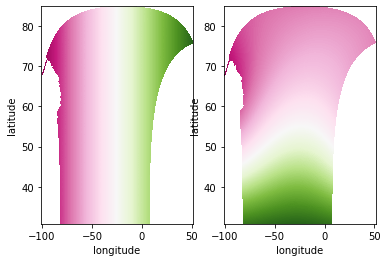

In [5]:
# Make a plot to verify that data have been loaded
# Using pcolormesh is good because it explicitly
# requires the pixel locations rather than implicit
# pixel locations with an image plotting tool.
import matplotlib.pyplot as plt
cmap = plt.get_cmap('PiYG')
# Use tuple unpacking to list the axes.
# See: https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html
fig, axs = plt.subplots(ncols=2)
axs[0].pcolormesh(glamt[1:im-2,1:jm-2],gphit[1:im-2,1:jm-2],glamt[1:im-2,1:jm-2], cmap=cmap)
#axs[1].pcolormesh(glamt[1:im-2,1:jm-2],gphit[1:im-2,1:jm-2],gphit[1:im-2,1:jm-2], cmap=cmap)
axs[1].pcolormesh(glamt[1:im-2,1:jm-2],gphit[1:im-2,1:jm-2],area[1:im-2,1:jm-2], cmap=cmap)

for ax in axs:
    ax.set(xlabel='longitude',ylabel='latitude')

plt.show()

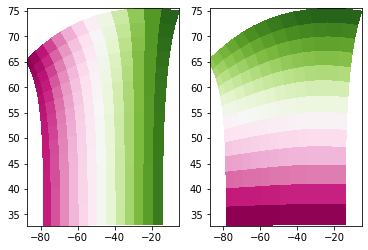

In [6]:
# Multiply arrays to be averaged by weight (area in this case)
glamt_w = np.multiply(glamt,area)
gphit_w = np.multiply(gphit,area)

# Create cut down versions of the lon, lat grids
for ii in range(1,imn):
    
    # Comments for index logic.  Same logic
    # for j direction.
    # For ii = 1, we want exactly 1.
    # For ii = imn, we want start of the last block,
    #  which is +1 of the end of the previous block.
    # Finally, note all subtract 1 because Python
    # index counting starts at 0.
    istart = 1+ibm*(ii-1) - 1
    
    # For ii = 1, we want the end of the first block
    # For ii = imn, we want the end of the last block
    iend = ibm*ii - 1
    
    for jj in range(1,jmn):

        jstart = 1+jbm*(jj-1) - 1 
        jend = jbm*jj - 1
        
        # We use area here (and not the masked area as below)
        # because glamt and gphit are coordinates and so they
        # have valid data over land as well as over the ocean.
        glamt_new[ii,jj,0,0,0,0] = np.sum(
            glamt_w[istart:iend,jstart:jend])/np.sum(area[istart:iend,jstart:jend])
        gphit_new[ii,jj,0,0,0,0] = np.sum(
            gphit_w[istart:iend,jstart:jend])/np.sum(area[istart:iend,jstart:jend])
        
# Plot to see if the results make sense
glamt_new_plt = np.squeeze(glamt_new)
gphit_new_plt = np.squeeze(gphit_new)
fig, axs = plt.subplots(ncols=2)
axs[0].pcolormesh(glamt_new_plt[1:imn-2,1:jmn-2],gphit_new_plt[1:imn-2,1:jmn-2],glamt_new_plt[1:imn-2,1:jmn-2], cmap=cmap)
axs[1].pcolormesh(glamt_new_plt[1:imn-2,1:jmn-2],gphit_new_plt[1:imn-2,1:jmn-2],gphit_new_plt[1:imn-2,1:jmn-2], cmap=cmap)

In [7]:
# Clear some extraneous variables before we do the heavy crunching.
del glamt_w
del gphit_w


In [8]:
# Load SSH data
(error_value, error_message) = pyferret.run('use /home/jovyan/data/V20_1948_2009_SSH.nc')

# Ideally, here we load the time step information
# and allow the code to automatically pull this
# from the data.  However, I'm not doing that here
# because I cannot load the whole file to memory
# and I don't want to do any text processing from
# the Ferret show data command.

In [12]:
# Now all we need to do is iterate over the time index,
# passing a new string object to ferret to get that field
# and then apply the blockmean operation on the field
# and store the output.  Note that range includes the
# first value but goes up to, but not to, the last value.
for ll in range(lstart, lend+1):
    # Test loop ranges
    print(str(ll))
    
    # Load data from this time step
    ferret_var = 'sossheig[d=2,l='+str(ll)+']'
    ssh_dict = pyferret.getdata(ferret_var,False)
    ssh = np.squeeze(ssh_dict['data'])
    ssh_w = np.multiply(ssh,area_masked)
    
    # Store time coordinate
    if ll == lstart:
        # Convert tuple to list to be able to append
        axis_coords = list(ssh_dict['axis_coords'])
    else:
        coords = ssh_dict['axis_coords']
        axis_coords[3] = np.append(axis_coords[3],coords[3],axis=0)
    
    # Find number of missing values and post warning if present
    missing = np.abs(ssh - ssh_dict['missing_value']) < 1.0E-5
    if np.sum(missing) > 0:
        print('Warning! Missing values dectected!')
    
    del ssh
    
    # Cut data down and save to array.  See
    # how glamt and gphit were cut down for
    # comments on the logic.
    for ii in range(1,imn):
        
        istart = 1+ibm*(ii-1) - 1
        iend = ibm*ii - 1
        
        for jj in range(1,jmn):
            
            jstart = 1+jbm*(jj-1) - 1 
            jend = jbm*jj - 1
        
            # Need to check for land (empty) data points
            # and ensure that fill values on land do not
            # "bleed" into the averages near the coast.
            denominator = np.sum(area_masked[istart:iend,jstart:jend])
            missing_value = ssh_dict['missing_value']
            if denominator == 0:
                ssh_new[ii,jj,0,ll-lstart,0,0] = missing_value[0]
            else:
                ssh_new[ii,jj,0,ll-lstart,0,0] = np.sum(
                ssh_w[istart:iend,jstart:jend])/denominator

731
732
733
734
735


In [13]:
# Assign metadata keys to variables to save.ssh_dict.keys()
# We need the following keys (see output of first cell)
# See example code at: https://ferret.pmel.noaa.gov/Ferret/documentation/pyferret/example-sessions-python
# And more detailed docs for the metadata at:
# https://ferret.pmel.noaa.gov/Ferret/documentation/pyferret/data-dictionaries
# dict_keys([
#   'title', # long title
#   'data', # assign ssh_new
#   'missing_value', # array([9.96920997e+36]) = no change, they are applied above.
#   'data_unit',  # 'm' - no change
#   'axis_types', # (6,6,7,4,7,7) = (abstract,abstract,empty,time,empty,empty) = no change
#   'axis_names', # ('X','Y','','TIME','','') = no change
#   'axis_units', # ('', '', '', 'CALTYPE_NOLEAP', '', '') = no change
#   'axis_coords' # needs to go (array([1:imn]),array([1:jmn]),None,array([[dates_of_slices]]),None,None)
# ])
ssh_dict['name'] = ssh_new
ssh_dict['title'] = 'Regridded ssh'
ssh_dict['data'] = ssh_new

# Reset the axis_coords in x and y directions.
# Include imn and jmn.
axis_coords[0] = np.arange(imn+1,dtype=float)
axis_coords[1] = np.arange(jmn+1,dtype=float)

# Convert list to tuple to match original format
# and assign.
ssh_dict['axis_coords'] = tuple(axis_coords)


(array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.782e+03, 1.783e+03,
        1.784e+03]),
 array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.717e+03, 1.718e+03,
        1.719e+03]),
 None,
 array([[  22,    1, 1958,   12,    0,    0]], dtype=int32),
 None,
 None)

In [11]:
ferret_var = 'sossheig[d=2,l='+str(ll)+']'
ssh_dict = pyferret.getdata('sossheig[d=2,l=1:5]',False)
ssh_dict['axis_coords']

(array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.782e+03, 1.783e+03,
        1.784e+03]),
 array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.717e+03, 1.718e+03,
        1.719e+03]),
 None,
 array([[   2,    1, 1948,   12,    0,    0],
        [   7,    1, 1948,   12,    0,    0],
        [  12,    1, 1948,   12,    0,    0],
        [  17,    1, 1948,   12,    0,    0],
        [  22,    1, 1948,   12,    0,    0]], dtype=int32),
 None,
 None)

In [ ]:
coords = ssh_dict['axis_coords']
coords[3][1]

In [ ]:
coords[3] = np.append(coords[3],coords[3],axis=0)


In [28]:
np.arange(1000000,dtype=float)

array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 9.99997e+05,
       9.99998e+05, 9.99999e+05])

In [29]:
im

1784